# Topological feature map
Reference: https://royalsocietypublishing.org/doi/full/10.1098/rsif.2017.0734

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sklearn
from sklearn import datasets
import pandas as pd
try:
    import umap
except ImportError:
    print("This example requires the UMAP library. You can install it with the command `!pip install umap-learn`")
import warnings
warnings.filterwarnings("ignore")

In [3]:
import kmapper as km
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import ipywidgets as ipw

In [4]:
import os 
data_dir = '../data/epi-ts/'
ts = os.listdir(data_dir);

Load the data

In [5]:
data = {}
epi = []
t = []
ids = []
count = 0;
labels = []
for i,x in enumerate(sorted(ts)[:3]): 
    #I'm just using the first three diseases here, you can probably do better 
    data[x] = pd.read_csv(data_dir+x, skiprows=2,na_values='-',dtype=np.float64);
    labels.extend([x.split('_')[0],i]*data[x].shape[1])
    filled = data[x].fillna(0);
    for col in filled.columns[2:]:
        ids.extend([count]*data[x].shape[0]);
        epi.extend(filled[col]);
        t.extend(range(data[x].shape[0]));
        count+=1;

In [8]:
import tsfresh as tsf
from tsfresh.feature_extraction.extraction import extract_features

Reshape the timeseries in a format that tsfresh understands

In [9]:
rdf = pd.DataFrame(np.array([ids,t,epi]).T, columns=['id','t','epi'])
rdf.shape

(312900, 3)

In [16]:
# !pip3 install statsmodels==0.12.2

In [15]:
test_df = extract_features(rdf,column_id='id', column_sort='t')

[autoreload of statsmodels.tools._testing failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/usr/local/lib/python3.9/site-packages/statsmodels/tools/_testing.py", lin

In [21]:
test_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [23]:
test_df.drop(['epi__abs_energy'],axis=1,inplace=True) #this is just because this feature produces errors

In [24]:
import time
mapper = km.KeplerMapper(verbose=0)
import umap
lens = mapper.fit_transform(np.array(test_df.values).T, projection=umap.UMAP(n_neighbors=10,
                                                        min_dist=0.5,
                                                        n_components=2,
                                                        metric='euclidean',
                                                        random_state=int(time.time())))

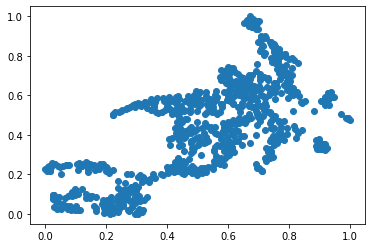

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.scatter(lens[:,0], lens[:,1])

In [26]:
# Get the simplicial complex  
scomplex = mapper.map(lens, test_df.values.T,
                      clusterer=sklearn.cluster.KMeans(n_clusters=2),#eps=0.5, min_samples=2),
                      cover=km.Cover(20, 0.8))

In [28]:
color_function = lens[:, 1]-lens[:, 1].min()
plotlyviz(scomplex, 
          title='Mapper graph of timeseries features',
          color_function=color_function, 
          color_function_name='Distance to y-min', 
          node_linecolor='rgb(100,100,100)',
          bgcolor='rgb(240,240,240)',
          width=620, height=620,
          summary_height=350,
          summary_left=10,
          hist_left=25,
          hist_right=10,
          graph_data=True)

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [29]:
color_function = lens[:, 1]-lens[:, 1].min()
plotlyviz(scomplex, 
          title='Mapper graph of timeseries features',
          color_function=color_function, 
          color_function_name='Distance to y-min', 
          node_linecolor='rgb(100,100,100)',
          bgcolor='rgb(240,240,240)',
          width=620, height=620,
          summary_height=350,
          summary_left=10,
          hist_left=25,
          hist_right=10,
          member_textbox_width=500,
          dashboard=True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

Let's save the result in html format and visualize it in interactive mode

In [30]:
labels_n = test_df.columns
# Tooltips with the membership labels for every cluster member
html =  mapper.visualize(scomplex,
                          path_html="keplermapper_feature_custom_tooltips.html",
                          custom_tooltips=labels_n)

In [39]:
from kmapper import jupyter # Creates custom CSS full-size Jupyter screen
jupyter.display(path_html="keplermapper_feature_custom_tooltips.html")

Let's label the diseases and see whether we can tell them apart from the features.  
You can assign the disease labels to the state data. 

In [32]:
classification_labels = [0]*60
classification_labels.extend([1]*60)
classification_labels.extend([2]*60)

And try to exploit the properties of the mapper graph to choose features wisely. 

In [55]:
g = km.to_networkx(scomplex);
import networkx as nx
GC = g.subgraph(list(nx.connected_components(g))[0]);
ecc = nx.eccentricity(GC)
# bet = nx.betweenness_centrality(GC)
# deg = dict(nx.degree(GC))

In [59]:
real_score = []
random_score = []

frac = 0.05
for topk in range(1,int(GC.number_of_nodes()*frac)):

    s = [(k, ecc[k]) for k in sorted(ecc, key=ecc.get, reverse=False)]
#     s = [(k, bet[k]) for k in sorted(bet, key=bet.get, reverse=True)]
#     s = [(k, deg[k]) for k in sorted(deg, key=deg.get, reverse=False)]
    selected_columns = []
    mem = nx.get_node_attributes(GC,'membership')
    cols = test_df.columns
    for k in range(topk):
        selected_columns.append(cols[mem[s[k][0]]][0]) 

    y = classification_labels    
    X = test_df[selected_columns]


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    print('Accuracy of Logistic regression classifier on training set: {:.2f}'
         .format(logreg.score(X_train, y_train)))
    print('Accuracy of Logistic regression classifier on test set: {:.2f}'
         .format(logreg.score(X_test, y_test)))
    real_score.append((logreg.score(X_train, y_train),logreg.score(X_test, y_test)))
    iterations = 20
    res = []

    for it in range(iterations):

        random_cols = np.random.choice(cols,len(selected_columns))
        X_random = test_df[random_cols]

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_random, y,random_state=int(time.time()))
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        res.append((logreg.score(X_train, y_train),logreg.score(X_test, y_test)));
    random_score.append((np.mean([x[0] for x in res]),np.mean([x[1] for x in res])))

Accuracy of Logistic regression classifier on training set: 0.46
Accuracy of Logistic regression classifier on test set: 0.42
Accuracy of Logistic regression classifier on training set: 0.40
Accuracy of Logistic regression classifier on test set: 0.40
Accuracy of Logistic regression classifier on training set: 0.41
Accuracy of Logistic regression classifier on test set: 0.44
Accuracy of Logistic regression classifier on training set: 0.42
Accuracy of Logistic regression classifier on test set: 0.42
Accuracy of Logistic regression classifier on training set: 0.44
Accuracy of Logistic regression classifier on test set: 0.44
Accuracy of Logistic regression classifier on training set: 0.50
Accuracy of Logistic regression classifier on test set: 0.44
Accuracy of Logistic regression classifier on training set: 0.59
Accuracy of Logistic regression classifier on test set: 0.62
Accuracy of Logistic regression classifier on training set: 0.70
Accuracy of Logistic regression classifier on test se

Text(0.5, 1.0, 'test')

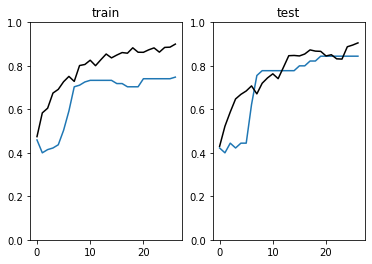

In [67]:
plt.subplot(121)
plt.plot([x[0] for x in real_score])
plt.plot([x[0] for x in random_score],'k')
plt.ylim(0,1)
plt.title('train')

plt.subplot(122)
plt.plot([x[1] for x in real_score])
plt.plot([x[1] for x in random_score],'k')
plt.ylim(0,1)
plt.title('test')

# Exercises 
- can you classify states instead of diseases?
- where do classically interesting features lie?
- etc 
